In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from optimization import *

In [2]:
def dm_reward(xWs, x_hats, phi, temp=0.02):
    actions = classify(x=x_hats, phi=phi, temp=temp)
    return torch.mean(torch.diag(xWs @ actions))

def phi_regularization(phi):
    return torch.norm(torch.norm(phi, dim=1) - 1)

def gr_phi(Xhats, xWs, u, prev_phi=None, 
           temp=0.02, attempts=5, iters=300): # no additional penalty for finding x?
    n, d = Xhats.shape
    m = u.shape[0]
    if prev_phi is None:
        phi = torch.rand((m, d))
        phi.requires_grad_(True)
    else:
        phi = torch.clone(prev_phi)
        phi.requires_grad_(True)
    best_phi = phi.clone()
    best_reward = dm_reward(xWs=xWs, x_hats=Xhats, phi=phi, temp=temp)
    for _ in range(attempts):
        optimizer = torch.optim.Adam([phi], lr=0.0001)
        for _ in tqdm(range(iters), position=0, leave=True):
            optimizer.zero_grad()
            loss = - dm_reward(xWs=xWs, x_hats=Xhats, phi=phi, temp=temp) # + phi_regularization(phi)
            loss.backward()
            optimizer.step()
            # print(loss)
        if loss < -best_reward:
            best_reward = -loss.detach()
            best_phi = phi.detach()
        phi = torch.rand((m, d))
        phi.requires_grad_(True)
    return best_phi


In [3]:
m = 2
d = 2
n = 1_000
dataset = torch.column_stack([torch.rand((n, d)), torch.ones(n)])
u = torch.tensor([0.15, 0.1])

In [4]:
phi = torch.tensor([[1., 0., 0.2], [1/np.sqrt(5), 2/np.sqrt(5), 0.]], dtype=torch.float32)
W = torch.tensor([[1., 1/np.sqrt(5)], [0., 2/np.sqrt(5)], [0.2, 0.0]], dtype=torch.float32)

In [5]:
# x_hat = torch.stack([gragent(x, phi, b, u, attempts=2, iters=200) for x in tqdm(dataset, position=0, leave=True)])

In [6]:
xW = dataset @ W

In [7]:
# -dm_reward(xW, dataset, phi, b, temp=0.02), -dm_reward(dataset @ W, dataset, phi_hat, b_hat, temp=0.02)

In [8]:
phi_hat = gr_phi(dataset, xW, u, temp=0.02, attempts=6, iters=2000)

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:06<00:00, 307.69it/s]


In [9]:
# classify(dataset[0], phi_hat, 0.02), phi_hat, phi

In [10]:
lbls = [a[0] > a[1] for a in classify(x=dataset, phi=phi, temp=0.02).T]
preds = [a[0] > a[1] for a in classify(x=dataset, phi=phi_hat, temp=0.02).T]

In [11]:
# phi_3 = torch.tensor([[1., 0., 0.2], [1/np.sqrt(5), 2/np.sqrt(5), 0.]], dtype=torch.float32)
# dataset_3 = torch.column_stack([torch.rand((n, d)), torch.ones(n)])
# lbls_3 = [a[0] > a[1] for a in classify(x=dataset_3, phi=phi_3, temp=0.02).T]
# plt.gca().set_aspect('equal')
# plt.scatter(dataset_3[:,0], dataset_3[:,1], c=lbls_3)

In [12]:
# phi_test_1 = [1.0, 0.0]
# phi_test_2 = [0.5, 1.0]
# phi_test_1 /= np.linalg.norm(phi_test_1)
# phi_test_2 /= np.linalg.norm(phi_test_2)

# phi_test = torch.tensor(
#     [phi_test_1, phi_test_2], dtype=torch.float32
# )
# lbls_test = [a[0] > a[1] for a in classify(x=dataset, phi=phi_test, temp=0.02).T]
# plt.gca().set_aspect('equal')
# plt.scatter(dataset[:,0], dataset[:,1], c=lbls_test)

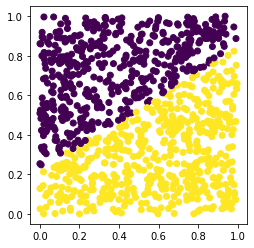

In [13]:
plt.gca().set_aspect('equal')
plt.scatter(dataset[:,0], dataset[:,1], c=lbls)

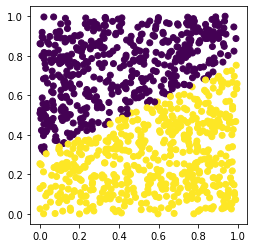

In [14]:
plt.gca().set_aspect('equal')
plt.scatter(dataset[:,0], dataset[:,1], c=preds)

In [15]:
phi

tensor([[1.0000, 0.0000, 0.2000],
        [0.4472, 0.8944, 0.0000]])

In [16]:
phi_hat

tensor([[0.8806, 0.5003, 0.9744],
        [0.7272, 0.8345, 0.8745]])